# _(Brette, et, al., 2007)_ COBA-HH

Implementation of the paper:

- Brette, R., Rudolph, M., Carnevale, T., Hines, M., Beeman, D., Bower, J. M., et al. (2007), Simulation of networks of spiking neurons: a review of tools and strategies., J. Comput. Neurosci., 23, 3, 349–98

which is based on the balanced network proposed by:

- Vogels, T. P. and Abbott, L. F. (2005), Signal propagation and logic gating in networks of integrate-and-fire neurons., J. Neurosci., 25, 46, 10786–95

In [1]:
import numpy as np
import brainpy as bp

bp.profile.set(jit=True, dt=0.1, numerical_method='exponential')

In [2]:
num_exc = 3200
num_inh = 800
Cm = 200  # Membrane Capacitance [pF]

gl = 10.  # Leak Conductance   [nS]
El = -60.  # Resting Potential [mV]
g_Na = 20. * 1000
ENa = 50.  # reversal potential (Sodium) [mV]
g_Kd = 6. * 1000  # K Conductance      [nS]
EK = -90.  # reversal potential (Potassium) [mV]
VT = -63.
Vt = -20.
# Time constants
taue = 5.  # Excitatory synaptic time constant [ms]
taui = 10.  # Inhibitory synaptic time constant [ms]
# Reversal potentials
Ee = 0.  # Excitatory reversal potential (mV)
Ei = -80.  # Inhibitory reversal potential (Potassium) [mV]
# excitatory synaptic weight
we = 6.  # excitatory synaptic conductance [nS]
# inhibitory synaptic weight
wi = 67.  # inhibitory synaptic conductance [nS]

In [3]:
neu_ST = bp.types.NeuState('V', 'm', 'n', 'h', 'sp', 'ge', 'gi')


@bp.integrate
def int_ge(ge, t):
    return - ge / taue


@bp.integrate
def int_gi(gi, t):
    return - gi / taui


@bp.integrate
def int_m(m, t, V):
    a = 13 - V + VT
    b = V - VT - 40
    m_alpha = 0.32 * a / (np.exp(a / 4) - 1.)
    m_beta = 0.28 * b / (np.exp(b / 5) - 1)
    dmdt = (m_alpha * (1 - m) - m_beta * m)
    return dmdt


@bp.integrate
def int_h(h, t, V):
    h_alpha = 0.128 * np.exp((17 - V + VT) / 18)
    h_beta = 4. / (1 + np.exp(-(V - VT - 40) / 5))
    dhdt = (h_alpha * (1 - h) - h_beta * h)
    return dhdt


@bp.integrate
def int_n(n, t, V):
    c = 15 - V + VT
    n_alpha = 0.032 * c / (np.exp(c / 5) - 1.)
    n_beta = .5 * np.exp((10 - V + VT) / 40)
    dndt = (n_alpha * (1 - n) - n_beta * n)
    return dndt


@bp.integrate
def int_V(V, t, m, h, n, ge, gi):
    g_na_ = g_Na * (m * m * m) * h
    g_kd_ = g_Kd * (n * n * n * n)
    dvdt = (gl * (El - V) + ge * (Ee - V) + gi * (Ei - V) -
            g_na_ * (V - ENa) - g_kd_ * (V - EK)) / Cm
    return dvdt


def neu_update(ST, _t):
    ST['ge'] = int_ge(ST['ge'], _t)
    ST['gi'] = int_gi(ST['gi'], _t)
    ST['m'] = int_m(ST['m'], _t, ST['V'])
    ST['h'] = int_h(ST['h'], _t, ST['V'])
    ST['n'] = int_n(ST['n'], _t, ST['V'])
    V = int_V(ST['V'], _t, ST['m'], ST['h'], ST['n'], ST['ge'], ST['gi'])
    sp = np.logical_and(ST['V'] < Vt, V >= Vt)
    ST['sp'] = sp
    ST['V'] = V


neuron = bp.NeuType(name='CUBA-HH', ST=neu_ST, steps=neu_update, mode='vector')


In [4]:
def exc_update(pre, post, pre2post):
    for pre_id in range(len(pre2post)):
        if pre['sp'][pre_id] > 0.:
            post_ids = pre2post[pre_id]
            # post['ge'][post_ids] += we
            for p_id in post_ids:
                post['ge'][p_id] += we


def inh_update(pre, post, pre2post):
    for pre_id in range(len(pre2post)):
        if pre['sp'][pre_id] > 0.:
            post_ids = pre2post[pre_id]
            # post['gi'][post_ids] += wi
            for p_id in post_ids:
                post['gi'][p_id] += wi


exc_syn = bp.SynType('exc_syn', steps=exc_update, ST=bp.types.SynState())

inh_syn = bp.SynType('inh_syn', steps=inh_update, ST=bp.types.SynState())


In [5]:
group = bp.NeuGroup(neuron, geometry=num_exc + num_inh, monitors=['sp'])
group.ST['V'] = El + (np.random.randn(num_exc + num_inh) * 5 - 5)
group.ST['ge'] = (np.random.randn(num_exc + num_inh) * 1.5 + 4) * 10.
group.ST['gi'] = (np.random.randn(num_exc + num_inh) * 12 + 20) * 10.

exc_conn = bp.SynConn(exc_syn, pre_group=group[:num_exc], post_group=group,
                      conn=bp.connect.FixedProb(prob=0.02))

inh_conn = bp.SynConn(inh_syn, pre_group=group[num_exc:], post_group=group,
                      conn=bp.connect.FixedProb(prob=0.02))

Compilation used 4.0441 s.
Start running ...
Run 10.0% used 0.075 s.
Run 20.0% used 0.151 s.
Run 30.0% used 0.227 s.
Run 40.0% used 0.303 s.
Run 50.0% used 0.380 s.
Run 60.0% used 0.459 s.
Run 70.0% used 0.534 s.
Run 80.0% used 0.610 s.
Run 90.0% used 0.687 s.
Run 100.0% used 0.762 s.
Simulation is done in 0.762 s.


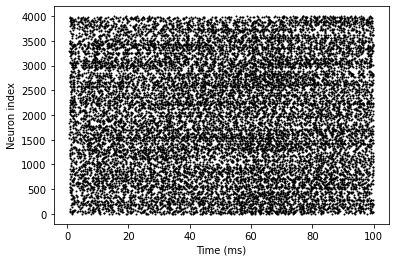

In [6]:
net = bp.Network(group, exc_conn, inh_conn)
net.run(100., report=True)
bp.visualize.raster_plot(net.ts, group.mon.sp, show=True)